## Sales Forecasting with Bayesian Inference

This notebook demonstrates the use of Bayesian inference for sales forecasting using various probabilistic programming techniques. We will use the `numpyro` library to define and fit our models, and `plotnine` for visualization.

## Introduction

Bayesian inference allows us to incorporate prior knowledge and quantify uncertainty in our predictions. This notebook will guide you through the process of building a Bayesian model for sales forecasting, fitting the model using Markov Chain Monte Carlo (MCMC) and Stochastic Variational Inference (SVI), and visualizing the results.

## Import Required Libraries And Define Functions

In [1]:
import os
import sys

# Set XLA_FLAGS before JAX is imported
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

In [2]:
import polars as pl
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_point, geom_line, labs, theme_minimal, theme_bw, scale_x_continuous, scale_x_discrete, scale_x_datetime
import patsy

import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import expit, logit

import numpyro
import numpyro.distributions as dist
#from numpyro.infer import SVI, Trace_ELBO, Predictive
from numpyro.infer import MCMC, NUTS, MCMC, NUTS #, SVI, Trace_ELBO
import arviz as az

#jax.config.update("jax_enable_x64", True)  # Enable float64 by default

/home/pavel/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.


## 1. Model

In this section, we define the Bayesian model used for sales forecasting. The model incorporates various components such as random walk for the latent state, day-of-the-week effects, day-of-the-year effects, and price elasticity. The model is implemented using the `numpyro` library, which allows for efficient and scalable Bayesian inference.

### 1.1 Auxiliary Functions

These auxiliary functions are essential for data preprocessing and transformation:

- `periodic_rbf`: Computes a periodic Gaussian radial basis function (RBF).
- `compute_doy_basis`: Computes 12 periodic Gaussian basis functions for seasonal effects.
- `read_data`: Reads and preprocesses the sales data from a CSV file.
- `init_values`: Initializes values for the model parameters.

In [3]:
# Define a periodic Gaussian radial basis function (RBF)
def periodic_rbf(x, mu, sigma):
    """
    Computes a periodic Gaussian radial basis function (RBF).
    
    Args:
        x: Scaled day-of-year values (range [0,1]).
        mu: Center of the Gaussian basis function.
        sigma: Controls the spread of the Gaussian.
    
    Returns:
        RBF values preserving periodicity.
    """
    # compute cyclic distance to mu
    periodic_distance = jnp.minimum(jnp.abs(x - mu), 1 - jnp.abs(x - mu))
    # compute RBF value
    return jnp.exp(- (periodic_distance ** 2) / (2 * sigma ** 2))

def compute_doy_basis(yday_fraction, sigma = 30/365.25, n_centers = 12):
    """
    Computes 12 periodic Gaussian basis functions for seasonal effects.
    
    Args:
        yday_fraction: Normalized day of the year (range [0,1]).
        yday_factor: Scaling factor for basis function width.
    
    Returns:
        A JAX array with 12 columns representing the 12 monthly basis functions.
    """
    # Define centers of Gaussian basis functions
    month_centers = jnp.linspace( 1/(2*n_centers), 1-1/(2*n_centers), n_centers)
    
    # Generate an array of shape (length of input, 12) with the RBF values
    doy_basis = jnp.stack([periodic_rbf(yday_fraction, mu, sigma) for mu in month_centers], axis=-1)

    # Subtract each row's mean to enforce sum-to-zero constraint
    doy_basis_centered = doy_basis - jnp.mean(doy_basis, axis=-1, keepdims=True)
    
    return doy_basis_centered

def read_data(fname, n_rows=None):
    """
    Reads and preprocesses the sales data from a CSV file.
    
    Args:
        fname: The filename of the CSV file containing the sales data.
    
    Returns:
        A dictionary with the following keys:
            - sales: An array of sales data.
            - log_price: An array of log-transformed prices.
            - wday: An array of day-of-the-week values.
            - yday_fraction: An array of normalized day-of-the-year values.
    """
    # Read the CSV file using polars
    df = pl.read_csv(fname)
    
    # Keep only the first n_rows if specified
    if n_rows is not None:
        df = df.head(n_rows)
    
    # Convert the 'date' column to date type
    df = df.with_columns(pl.col("date").str.to_date())

    # Extract sales, and log price data as a numpy arrays
    sales = df["sales"].to_numpy()
    log_price = df["log_price"].to_numpy()
    
    # Extract day-of-the-week values
    wday = df["date"].dt.weekday().to_numpy() # set offset to 0
            
    # Extract day-of-the-year values
    yday = df["date"].dt.ordinal_day().to_numpy()
    
    # Determine if the year is a leap year
    is_leap_year = df["date"].dt.is_leap_year().to_numpy()
    
    # Normalize day-of-the-year values
    yday_fraction = yday / (365 + is_leap_year)
    
    # Return the preprocessed data as a dictionary
    return {
        "date": df["date"].to_numpy(),
        "sales": sales,
        "log_price": log_price,
        "wday": wday,
        "yday_fraction": yday_fraction
    }

def interpolate(x, downsampling_factor, n_out):
    """
    """
    idx_n_weight = jnp.array(range(0, n_out))/jnp.float64(downsampling_factor)
    idx_1 = jnp.array( jnp.floor(idx_n_weight), dtype=int)
    idx_2 = jnp.array( jnp.ceil(idx_n_weight), dtype=int)
    weight_2 = idx_n_weight - idx_1

    state_before = x[idx_1]
    state_after  = x[idx_2]

    return (1-weight_2)*state_before + weight_2*state_after

def chunked_mean(x, n_chunk):
    n = x.shape[0]
    pad_size = -n % n_chunk # compute padding needed to make k a multiple of n
    x_padded = jnp.pad(array = x, pad_width = (0, pad_size), mode = 'edge') # pad at the end
    return x_padded.reshape(-1, n_chunk).mean(axis=1)

def chunked_sum(x, n_chunk):
    n = x.shape[0]
    pad_size = -n % n_chunk # compute padding needed to make k a multiple of n
    x_padded = jnp.pad(array = x, pad_width = (0, pad_size)) # pad at the end
    return x_padded.reshape(-1, n_chunk).sum(axis=1)

In [4]:
# Creates a simple plot using plotnine
def plot_function(x, y, title, xlab, ylab):
    # Convert x to numpy array
    x = np.array(x)
    
    # Check if y is a callable function
    if callable(y):
        # If y is a function, apply it to x and create a DataFrame
        df = pd.DataFrame({"x": x, "y": y(x)})
    else:
        # If y is not a function, create a DataFrame directly
        df = pd.DataFrame({"x": x, "y": y})        

    # Create the plot using ggplot
    plot = (ggplot(df, aes(x="x", y="y")) + geom_line() + labs(title=title, x=xlab, y=ylab) + theme_bw())
    
    # Return the plot
    return plot

### 1.2 Model

#### 1.2.1 Key Features

- Sales are modeled using a **stochastic Poisson process**, where the expected rate $\lambda_t$ evolves over time.
- The **latent sales rate** follows a random walk, allowing it to drift nonstationarily.
- **Seasonal components** (day-of-the-week and annual patterns) adjust for structured demand variations.
- **Price elasticity** is explicitly modeled, ensuring sensitivity to pricing dynamics.
- The model is implemented in numpyro, enabling scalable Bayesian inference.


#### 1.2.1 Model Overview

We model the sales time series as a **stochastic process** where the underlying rate of sales evolves over time. This evolution follows a **random walk structure**, but with systematic adjustments for covariates such as price, day-of-the-week effects, and day-of-the-year effects. The rate of sales $\lambda_t$ on day $t$ is a function of captures *(i)* systematic covariate effects ($z_t$), *(ii)*
a global baseline ($\mu_\tau$), and *(iii)* the latent dynamic component ($\tau_t$).

$$
log~\lambda_t = z_t + \mu_\tau + \tau_t
$$

##### 1.2.1.1 Latent States Dynamics

The baseline sales level $\tau_t$ follows a **random walk**. Because all contrast matrices for structured effects are centered, $\mu_\tau + \tau_t$ can be interpreted as the average latent sales rate on $\tau_t$. 

$$
\tau_t = \tau_{t-1} + \delta_t, \quad \delta_t \sim \mathcal{N}(0, \sigma_\tau)
$$

with:

$$
\mu_\tau \sim \text{Exponential}(1), \quad \sigma_\tau \sim \mathcal{N}(1)
$$


##### 1.2.1.2 Structured Effects

We further accounted for systematic effects of *(i)* day of the week, *(ii)* day of the year, and *(iii)* price.

- For day of the week effects, we used a contrast matrix $\mathbf{C}_{\text{wday}}$ with sliding differences.
- For day of the year effects, we used a matrix of Gaussian radial basis functions $\mathbf{B}_{\text{yday}}$.
- Price elasticity is modelled using a centered log price 

Similarly, the day-of-the-year effects are modeled using a seasonality basis matrix $\mathbf{B}_{\text{yday}}$, which represents periodic seasonal patterns using Gaussian radial basis functions (RBFs).


- **Day-of-the-week effects**:

$$
  zw_t = \mathbf{C}_{\text{wday}} \cdot \beta_{\text{wday}}, \quad \beta_{\text{wday}} \sim \mathcal{N}(0, 1)
$$

- **Day-of-the-year effects**:

$$
  zy_t = \mathbf{B}_{\text{yday}} \cdot \beta_{\text{yday}}, \quad \beta_{\text{yday}} \sim \mathcal{N}(0, 1)
$$

- **Price elasticity**:

$$
  ze_t = \text{log\_price\_centered} \cdot e, \quad \log(-e) \sim \mathcal{N^{+}}(0, 1)
$$

- **Sum of structural effects**:

$$
  z_t = zw_t + zy_t + ze_t
$$


##### 1.2.1.3 Emissions Model

Observed sales are assumed to follow a **Poisson distribution**, ensuring discrete, non-negative observations:

$$
S_t \sim \text{Poisson}(\lambda_t)
$$


In [5]:
def model_local_level_poisson(sales: jnp.array, log_price_centered: jnp.array, wday: jnp.array, yday_fraction: jnp.array, 
                              contrasts_sdif_t: jnp.array, contrasts_wday: jnp.array, contrasts_yday: jnp.array, 
                              downsampling_factor = 1):
    """
    """

    n_obs = len(sales)
    n_states = contrasts_sdif_t.shape[0]
 
    def sample_random_walk(contrasts_sdif_t, n_states):
        log_sigma = numpyro.sample("log_sigma", dist.Gumbel(0, 5))
        sigma = numpyro.deterministic("sigma", jnp.exp(log_sigma))
        log_state_mean = numpyro.sample("log_state_mean", dist.Normal(0, 5)) # to-do: add an average drift term, as well as potentially an additional parameter governing drift dynamics 
        log_state_delta = numpyro.sample( "log_state_delta", dist.Normal(0, 1), sample_shape=(n_states-1,))
        log_state_base = numpyro.deterministic("log_state_base", jnp.dot(contrasts_sdif_t, log_state_delta) * sigma + log_state_mean )
        return log_state_base

    def sample_downsampled_random_walk(contrasts_sdif_t, n_obs, n_states):
        log_state_base_downsampled = sample_random_walk(contrasts_sdif_t, n_states)
        log_state_base = interpolate(log_state_base_downsampled, downsampling_factor, n_obs)
        return log_state_base
        
    def sample_wday_effect(contrasts_wday, wday):
        # Prior for day-of-the-week effects (6 coefficients)
        wday_coefficients = numpyro.sample("wday_coefficients", dist.Normal(0, 1), sample_shape=(6,))

        # Compute wday effect per observation (sum-to-zero constraint applied via contrasts)
        wday_effects = jnp.dot(contrasts_wday, wday_coefficients)
        return jnp.array(wday_effects[wday-1])

    def sample_yday_effect(contrasts_yday, yday_fraction):
        # Prior for yearly seasonality effects (12 coefficients)
        yday_coefficients = numpyro.sample("yday_coefficients", dist.Normal(0, 1), sample_shape=(12,))
        return jnp.dot(contrasts_yday, yday_coefficients)

    def sample_price_effect(log_price_centered):
        # Prior for price elasticity
        elasticity_pos = numpyro.sample( "elasticity_pos", dist.HalfNormal(5) )
        elasticity = numpyro.deterministic("elasticity", -1 * elasticity_pos)
        return log_price_centered * elasticity


    # Sample random walk    
    if n_obs == n_states:
        log_state_base = sample_random_walk(contrasts_sdif_t, n_states)
    else:
        log_state_base = sample_downsampled_random_walk(contrasts_sdif_t, n_obs, n_states)

    # Sample day-of-the-week effects
    wday_effect = sample_wday_effect(contrasts_wday, wday)

    # Sample day-of-the-year effects
    yday_effect = sample_yday_effect(contrasts_yday, yday_fraction)

    # Sample elasticity effect
    price_effect = sample_price_effect(log_price_centered)

    # Compute state
    state = numpyro.deterministic("state", jnp.exp( log_state_base  + yday_effect + wday_effect + price_effect )) #   # 

    # Compute log-likelihood for poisson emissions
    numpyro.sample("sales", dist.Poisson(rate=state), obs=sales) # to-do: create a Poisson distribution paramaterized by log-rate, as in the Stan manual 

## 2. Fit the Model 

We use the `run_nuts` function to fit the model to our sales data. The function leverages the No-U-Turn Sampler (NUTS) from the `numpyro` library to perform MCMC sampling.
Because the model has a large number of latent parameters, initialization to sensible start values is key.


### 2.1 Model Fitting Logic

In order to fit the model, the functions below are used:

1. `prepare_model_arguments`: Transforms the data into a format required by the model, including sales data, log-transformed prices, day-of-the-week values, and normalized day-of-the-year values.

2. `init_values`: Finds sensible start values for the model parameters which, in this case is crucial for the convergence of the MCMC algorithm.

2. `run_nuts`: Given a dataset, it calls the NUTS sampler to perform MCMC sampling.

In [6]:
def init_values(sales: jnp.array, log_price_centered: jnp.array, wday, yday_fraction: jnp.array, downsampling_factor = 1):
    """
    """
    epsilon = 0.001
    log_state_est = jnp.log(sales + epsilon)
    log_state_mean_est = jnp.mean(log_state_est)
    log_state_delta_est = jnp.diff(log_state_est)
    if downsampling_factor > 1:
        log_state_delta_est = chunked_sum(log_state_delta_est, downsampling_factor)
        
    log_state_delta_sd_est = jnp.std(log_state_delta_est)

    return {
        "log_sigma": jnp.log( log_state_delta_sd_est ),
        "log_state_mean": log_state_mean_est,
        "log_state_delta": log_state_delta_est,
        "wday_coefficients": jnp.array([0.0]*6),
        "yday_coefficients": jnp.array([0.0]*12),
        "log_elasticity": jnp.array([0.0])
    }

In [7]:
def prepare_model_arguments(sales: jnp.array, log_price: jnp.array, wday: jnp.array, yday_fraction: jnp.array, downsampling_factor = 1):
    """ 
    Prepares the arguments required for the model.
    
    Args:
        sales: Array of sales data.
        log_price: Array of log-transformed prices.
        wday: Array of day-of-the-week values.
        yday_fraction: Array of normalized day-of-the-year values.
        downsampling_factor: Factor by which to downsample the data.
    
    Returns:
        A tuple containing initialized values for the model parameters and the model arguments.
    """    
    n_obs = len(sales)
    
    # Determine the number of states based on the downsampling factor
    if downsampling_factor == 1:
        n_states = n_obs
    else:
        n_states = int(np.ceil(n_obs / downsampling_factor) + 1)
    
    # Define contrast matrix for random walk (T coefficients, sum-to-zero constraint)
    contrasts_sdif_t = patsy.contrasts.Diff().code_without_intercept(range(0, n_states)).matrix

    # Define contrast matrix for day-of-the-week effects (6 coefficients, sum-to-zero constraint)
    contrasts_wday = patsy.contrasts.Diff().code_without_intercept(range(0, 7)).matrix  # 7 days → 6 contrasts

    # Compute yday effect per observation (sum-to-zero constraint applied via contrasts)
    contrasts_yday = compute_doy_basis(yday_fraction, sigma=30/365.25, n_centers=12) # to-do: do a very approximate calibration of the RBF width parameter sigma, using something like a spline for the long term trend + RBF seasonality

    # Compute centered log price differences
    log_price_centered = log_price - jnp.mean(log_price)

    # Set up the model parameters
    model_arguments = {
        'sales': sales,
        'log_price_centered': log_price_centered,
        'wday': jnp.array(wday, dtype=int),
        'yday_fraction': yday_fraction,
        'downsampling_factor': downsampling_factor,
        'contrasts_sdif_t': contrasts_sdif_t,
        'contrasts_wday': contrasts_wday,
        'contrasts_yday': contrasts_yday
    }
    
    # Prepare initial values for parameters 
    init_params = init_values(sales, log_price_centered, wday, yday_fraction, downsampling_factor)

    return init_params, model_arguments


In [8]:
def run_nuts(sales: jnp.array, log_price: jnp.array, wday, yday_fraction: jnp.array, downsampling_factor = 1, n_chains = 1, num_warmup=1_000, num_samples=1_000, step_size=0.01, max_tree_depth=8):
    """ Runs NUTS MCMC inference on the model 
    """
    # Initialize random number generator key
    rng_key = random.PRNGKey(0)
    
    # Get the number of observations
    n_obs = len(sales)
    
    # Prepare model arguments and initial parameter values
    init_params, model_arguments = prepare_model_arguments(sales = sales, log_price = log_price, wday = wday, yday_fraction = yday_fraction, downsampling_factor = downsampling_factor)

    # Split the random number generator key
    rng_key, rng_key_ = random.split(rng_key)

    # Set the number of chains for parallel sampling
    numpyro.set_host_device_count(n_chains)

    # Define the model to be used
    reparam_model = model_local_level_poisson
    
    # Initialize the NUTS kernel with the specified step size and tree depth
    kernel = NUTS(reparam_model, step_size=step_size, max_tree_depth=max_tree_depth)
    
    # Initialize the MCMC sampler with the NUTS kernel
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=n_chains)
    
    # Run the MCMC sampler
    mcmc.run(rng_key_, **model_arguments) # disable init values: init_params=init_params

    # Return the fitted MCMC object
    return mcmc, model_arguments

### 2.2 Fit the Model to the Synthetic Dataset
- We fit the model to the synthetic dataset using the `run_nuts` function. The model is fitted using the No-U-Turn Sampler (NUTS) from the `numpyro` library, with 4 chains, 1,000 warmup iterations, and 1,000 sampling iterations. The step size is set to 0.01, and the maximum tree depth is 8. The fitted model is stored in the `m_fit` variable.
- On CPU, the process takes about 2 minutes.

In [9]:
# read in the synthetic sales data
data = read_data("sales_synthetic.csv")

In [10]:
# Fit the model using NumPyro NUTS MCMC
m_fit, model_arguments = run_nuts(data['sales'], data['log_price'], data['wday'], data['yday_fraction'], 
                                    downsampling_factor=7, n_chains=4, num_warmup=1_000, num_samples=1_000,
                                    step_size=0.01, max_tree_depth=8)

/home/pavel/.local/lib/python3.10/site-packages/jax/_src/numpy/scalar_types.py:49: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

### 2.3 Inspect the MCMC results

All effective sample sizes are decent, which is a good sign. The Gelman-Rubin statistics are close to 1, indicating convergence. Inspection of trace plots are beyond the scope of this notebook.

#### 2.3.1 Random Walk Component

In [11]:
# Let's look at the estimated random walk component of the model.
az.summary(m_fit, var_names=["sigma", "log_state_delta"], filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_sigma,-2.823,0.104,-3.016,-2.634,0.003,0.002,1122.0,2413.0,1.0
log_state_delta[0],0.318,0.943,-1.389,2.129,0.016,0.014,3278.0,2661.0,1.0
log_state_delta[1],0.296,0.892,-1.344,1.987,0.016,0.015,3255.0,2471.0,1.0
log_state_delta[2],0.197,0.907,-1.465,1.887,0.016,0.013,3033.0,2899.0,1.0
log_state_delta[3],-0.510,0.901,-2.138,1.231,0.017,0.014,2832.0,2800.0,1.0
...,...,...,...,...,...,...,...,...,...
log_state_delta[194],0.577,0.648,-0.715,1.738,0.013,0.009,2512.0,2770.0,1.0
log_state_delta[195],-0.733,0.668,-1.988,0.508,0.014,0.009,2428.0,2691.0,1.0
log_state_delta[196],-0.666,0.650,-1.979,0.462,0.012,0.009,2785.0,2337.0,1.0
log_state_delta[197],-0.577,0.840,-2.192,0.963,0.014,0.013,3504.0,3042.0,1.0


Here, we'll plot the estimated the random walk component, which also incorporates long term trends and growth or decline of sales. For present purposes, this is what amounts to irrelevant noise in the model.

/home/pavel/.local/lib/python3.10/site-packages/jax/_src/numpy/scalar_types.py:49: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.


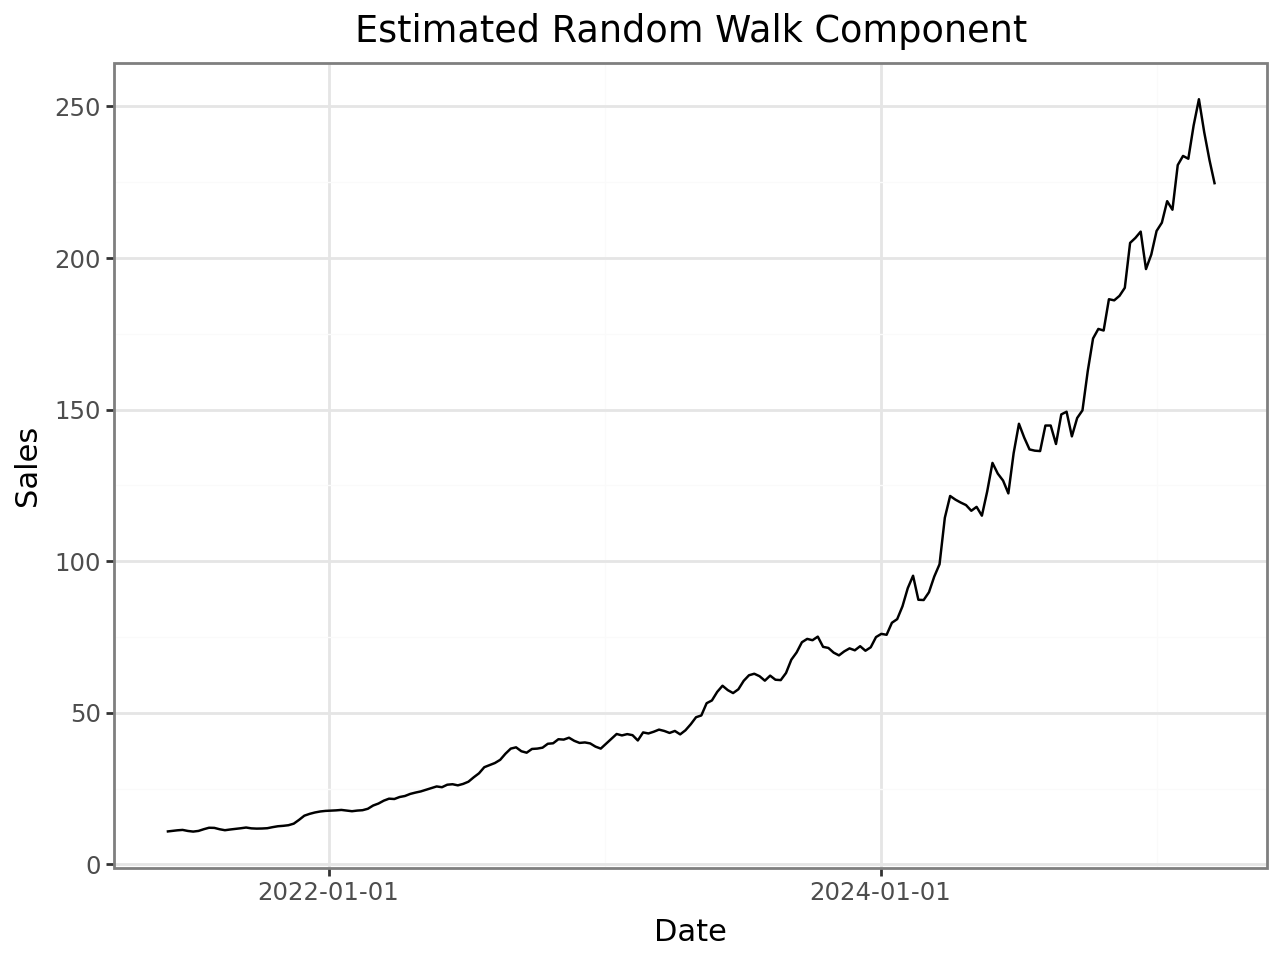

In [12]:
# Create a sequence of dates starting at data["date"].min() the length of x['mean'], in steps of 7 days
rw_states = az.summary(m_fit, var_names=["log_state_base"], filter_vars="like")["mean"].to_numpy()
dates = pd.date_range(start = data["date"].min(), periods = len(rw_states), freq='7D')
plot_function(dates, np.exp(rw_states), "Estimated Random Walk Component", "Date", "Sales") # to-do: add uncertainty bands

#### 2.3.2 Day of the Week Effects

In [ ]:
coefs_wday = az.summary(m_fit, var_names=["wday_coefficients"], filter_vars="like")
coefs_wday

/home/pavel/.local/lib/python3.10/site-packages/jax/_src/numpy/scalar_types.py:49: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
wday_coefficients[0],-0.022,0.012,-0.046,0.000,0.0,0.0,3461.0,2405.0,1.0
wday_coefficients[1],-0.103,0.012,-0.127,-0.080,0.0,0.0,2395.0,3019.0,1.0
wday_coefficients[2],-0.062,0.013,-0.086,-0.038,0.0,0.0,2662.0,2699.0,1.0
wday_coefficients[3],0.000,0.013,-0.024,0.025,0.0,0.0,2480.0,2377.0,1.0
wday_coefficients[4],0.078,0.012,0.053,0.100,0.0,0.0,2509.0,2922.0,1.0
wday_coefficients[5],0.067,0.012,0.045,0.090,0.0,0.0,3248.0,2802.0,1.0


Here, we'll plot the estimated weekly seasonality.

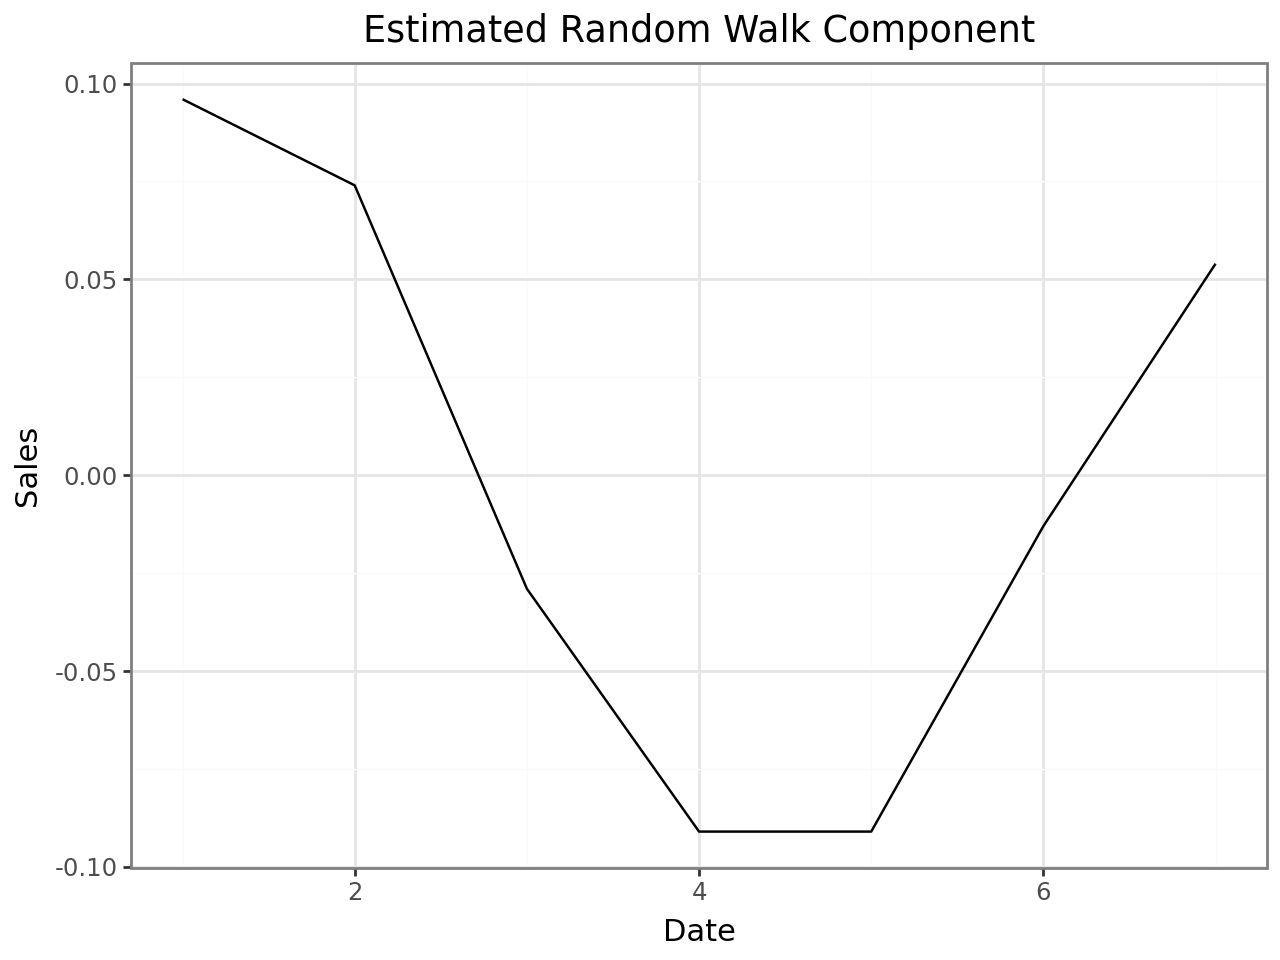

In [ ]:
wday_effect = jnp.dot(model_arguments["contrasts_wday"], jnp.array(coefs_wday["mean"]))
plot_function(range(1,8), wday_effect, "Effect of Day of the Week", "Date", "Sales") # to-do: add uncertainty bands

#### 2.3.3 Yearly Seasonality Effects

In [16]:
coefs_yday = az.summary(m_fit, var_names=["yday_coefficients"], filter_vars="like")
coefs_yday

/home/pavel/.local/lib/python3.10/site-packages/jax/_src/numpy/scalar_types.py:49: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
yday_coefficients[0],-0.086,0.366,-0.770,0.606,0.017,0.008,453.0,889.0,1.01
yday_coefficients[1],-0.074,0.376,-0.786,0.620,0.018,0.008,459.0,1127.0,1.00
yday_coefficients[2],-0.053,0.372,-0.797,0.600,0.018,0.009,449.0,774.0,1.01
yday_coefficients[3],-0.043,0.384,-0.764,0.667,0.018,0.008,468.0,1283.0,1.00
yday_coefficients[4],0.137,0.370,-0.578,0.797,0.018,0.009,446.0,808.0,1.00
yday_coefficients[5],-0.121,0.375,-0.854,0.571,0.018,0.009,458.0,1064.0,1.00
yday_coefficients[6],0.215,0.372,-0.442,0.985,0.018,0.009,431.0,854.0,1.00
yday_coefficients[7],-0.054,0.366,-0.736,0.665,0.017,0.009,451.0,931.0,1.00
yday_coefficients[8],0.096,0.372,-0.656,0.744,0.017,0.009,457.0,887.0,1.00
yday_coefficients[9],-0.123,0.369,-0.810,0.593,0.018,0.010,443.0,914.0,1.00


In [17]:
yday_effect = jnp.dot(model_arguments["contrasts_yday"], jnp.array(coefs_yday["mean"]))
plot_function(range(1,13), yday_effect, "Estimated Random Walk Component", "Date", "Sales") # to-do: add uncertainty bands

ValueError: All arrays must be of the same length

In [ ]:
#### 2.3.4 Price Elasticity

In [ ]:
az.summary(m_fit, var_names=["elasticity"])

In [ ]:
x = pd.DataFrame({ 'date': df["date"].to_numpy(), 'sales': df["sales"].to_numpy(), 'state': m['state'] })
ggplot(x, aes(x='date', y='sales')) + geom_point() + geom_line(aes(y='state'), color = "red") + theme_bw()